<a href="https://colab.research.google.com/github/amrirasyidi/ztm_pytorch_learn/blob/main/09_pytorch_model_deployment_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment Exercises

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7dbcd92b3460>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

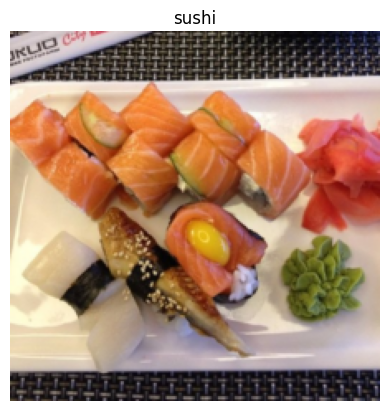

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [10]:
# TODO: your code

import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

In [11]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [12]:
# initiate effnetb2

enet_b2_weight = torchvision.models.EfficientNet_B2_Weights.DEFAULT
enet_b2 = torchvision.models.efficientnet_b2(weights = enet_b2_weight)

for parameter in enet_b2.parameters():
    parameter.requires_grad = False

enet_b2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=1408, out_features=3)
)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 76.8MB/s]


In [13]:
summary(model=enet_b2,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [14]:
enet_b2_transform = enet_b2_weight.transforms()

In [15]:
# Create data loaders
train_dataloader_enet_b2, test_dataloader_enet_b2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=enet_b2_transform, # use manually created transforms
    batch_size=BATCH_SIZE
)

In [16]:
# # effnetb2 on gpu training

# enet_optim = torch.optim.Adam(params=enet_b2.parameters(), lr = 1e-3)
# enet_loss_fn = torch.nn.CrossEntropyLoss()

# enet_result = engine.train(
#     model=enet_b2,
#     train_dataloader=train_dataloader,
#     test_dataloader=test_dataloader,
#     optimizer=enet_optim,
#     loss_fn=enet_loss_fn,
#     epochs = 5,
#     device = device
# )

In [17]:
# enetb2 on gpu prediction
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

enet_predlist = pred_and_store(
    paths=test_data_paths,
    model=enet_b2,
    transform=enet_b2_transform,
    class_names=class_names,
    device=device
)

  0%|          | 0/150 [00:00<?, ?it/s]

In [18]:
enet_pred_times = [pred["time_for_pred"] for pred in enet_predlist]

In [19]:
import pandas as pd

time_df = pd.DataFrame(data = enet_pred_times, columns = ['enet_b2'])
# time_df.head()

,enet_b2
0,0.2781
1,0.0927
2,0.0549
3,0.0382
4,0.0679


In [20]:
# vit on gpu

vit_weight = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_transforms = vit_weight.transforms()
vit = torchvision.models.vit_b_16(weights = vit_weight)

for parameter in vit.parameters():
    parameter.requires_grad = False

vit.heads = nn.Sequential(
    nn.Linear(in_features=768, # keep this the same as original model
    out_features=len(class_names)) # update to reflect target number of classes
)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 55.2MB/s]


In [21]:
vit_gpu_predlist = pred_and_store(
    paths=test_data_paths,
    model=vit,
    transform=vit_transforms,
    class_names=class_names,
    device=device
)

vit_gpu_pred_times = [pred["time_for_pred"] for pred in vit_gpu_predlist]

  0%|          | 0/150 [00:00<?, ?it/s]

In [22]:
time_df['vit_gpu'] = vit_gpu_pred_times
# time_df.head()

,enet_b2,vit_gpu
0,0.2781,0.1594
1,0.0927,0.0395
2,0.0549,0.0397
3,0.0382,0.0331
4,0.0679,0.0362


In [23]:
# vit on cpu

vit_cpu_predlist = pred_and_store(
    paths=test_data_paths,
    model=vit,
    transform=vit_transforms,
    class_names=class_names,
    device='cpu'
)

vit_cpu_pred_times = [pred["time_for_pred"] for pred in vit_cpu_predlist]

  0%|          | 0/150 [00:00<?, ?it/s]

In [24]:
time_df['vit_cpu'] = vit_cpu_pred_times
# time_df.head()

,enet_b2,vit_gpu,vit_cpu
0,0.2781,0.1594,0.7789
1,0.0927,0.0395,0.5589
2,0.0549,0.0397,0.5678
3,0.0382,0.0331,0.5819
4,0.0679,0.0362,0.5657


In [25]:
import numpy as np

xaxis = np.linspace(1, len(time_df), len(time_df)).tolist()

<Axes: >

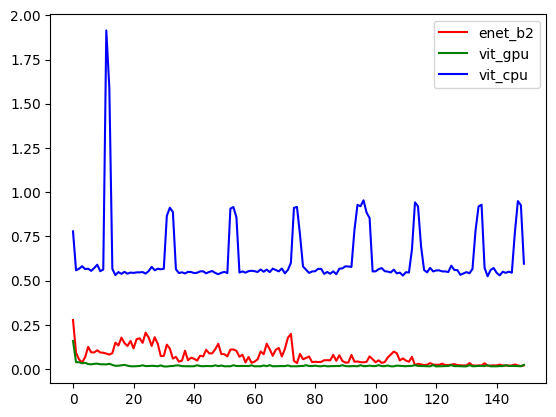

In [26]:
# plot the graph

fig, ax = plt.subplots()

time_df.plot.line(y='enet_b2', use_index=True, ax=ax, color='red')
time_df.plot.line(y='vit_gpu', use_index=True, ax=ax, color='green')
time_df.plot.line(y='vit_cpu', use_index=True, ax=ax, color='blue')

## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

In [39]:
# Create another ViT feature model instance

vit_food20_weight = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_food20_transforms = vit_food20_weight.transforms()
vit_food20 = torchvision.models.vit_b_16(weights = vit_food20_weight)

for parameter in vit.parameters():
    parameter.requires_grad = False

vit_food20.heads = nn.Sequential(
    nn.Linear(in_features=768, # keep this the same as original model
    out_features=101) # update to reflect target number of classes
)

In [34]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_food20_transforms,
])

food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [35]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_food20_transforms, # perform normal ViT transforms on test data
                             download=True)

100%|██████████| 4996278331/4996278331 [04:12<00:00, 19777818.05it/s]


Extracting data/food-101.tar.gz to data


In [36]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [37]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [38]:
# Turn torch Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 2
train_dataloader_food101 = DataLoader(train_data_food101_20_percent,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=NUM_WORKERS)

test_dataloader_food101 = DataLoader(test_data_food101_20_percent,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

len(train_dataloader_food101), len(test_dataloader_food101)

(474, 158)

In [40]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer
optimizer = torch.optim.Adam(params=vit_food20.parameters(),
                             lr=1e-3)

# Train the model
set_seeds()
vit_food101_20_percent_results = engine.train(model=vit_food20,
                                              train_dataloader=train_dataloader_food101,
                                              test_dataloader=test_dataloader_food101,
                                              epochs=5,
                                              optimizer=optimizer,
                                              loss_fn=loss_fn,
                                              device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6212 | train_acc: 0.0160 | test_loss: 4.4743 | test_acc: 0.0264
Epoch: 2 | train_loss: 4.4620 | train_acc: 0.0349 | test_loss: 4.3448 | test_acc: 0.0481
Epoch: 3 | train_loss: 4.3561 | train_acc: 0.0511 | test_loss: 4.2135 | test_acc: 0.0772
Epoch: 4 | train_loss: 4.2861 | train_acc: 0.0632 | test_loss: 4.1320 | test_acc: 0.0863
Epoch: 5 | train_loss: 4.3893 | train_acc: 0.0489 | test_loss: 4.2135 | test_acc: 0.0701


## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

In [ ]:
# Loop through test DataLoader (with batch size 1)
# Make prediction with model
# Store prediction and prediction probability to dictionary
# Append dictionary to list
# Inspect list

# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_batch_size_1 = DataLoader(test_data_food101_20_percent,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  num_workers=NUM_WORKERS)

# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food20.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_pred_list = []
for X, y in tqdm(test_dataloader_food101_batch_size_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)

  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_pred_list.append(pred_dict)

In [32]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 7.8 MB/s eta 0:00:00
mlxtend version: 0.22.0


In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [ ]:
# TODO: your code

## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

In [ ]:
# TODO: your answer to the above

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

In [ ]:
# TODO: your answer to the above

## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

In [12]:
# basic
import os
import pathlib
import random

from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image

In [13]:
RANDOM_SEED = 42
BATCH_SIZE = 64

In [14]:
# Download pizza, steak, sushi images from GitHub
original_eurosat_path = download_data(source="http://madm.dfki.de/files/sentinel/EuroSAT.zip",
                                     destination="EuroSAT")

original_eurosat_path

[INFO] data/EuroSAT directory exists, skipping download.


PosixPath('data/EuroSAT')

In [15]:
# Prepare the folder and its name
root_dir = os.getcwd()
root_dir = pathlib.Path(root_dir)

data_path = root_dir / "data"
original_eurosat_path = data_path / "EuroSAT" / "2750"
new_eurosat_path = data_path / "EuroSAT_reorganized"

# Setup train, valid, and testing paths
train_path = new_eurosat_path / "train"
valid_path = new_eurosat_path / "valid"
test_path = new_eurosat_path / "test"

In [16]:
# %%writefile going_modular/going_modular/custom.py
import shutil
import os
def reorganize_folder_structure(
        source_folder,
        destination_folder,
        train_ratio,
        valid_ratio,
        random_seed,
        if_exist,
        ):
    """
    reorg the folder to meet the pytorch dataloader criteria
    """
    # Create the destination folders
    train_folder = destination_folder / "train"
    valid_folder = destination_folder / "valid"
    test_folder = destination_folder / "test"
    os.makedirs(train_folder, exist_ok=if_exist)
    os.makedirs(valid_folder, exist_ok=if_exist)
    os.makedirs(test_folder, exist_ok=if_exist)

    # Loop through the source folder
    for class_folder in os.listdir(source_folder):
        if os.path.isdir(os.path.join(source_folder, class_folder)):
            # Create the destination class folders
            train_class_folder = train_folder / class_folder
            valid_class_folder = valid_folder / class_folder
            test_class_folder = test_folder / class_folder
            os.makedirs(train_class_folder, exist_ok=if_exist)
            os.makedirs(valid_class_folder, exist_ok=if_exist)
            os.makedirs(test_class_folder, exist_ok=if_exist)

            # Get the list of image files in the class folder
            image_files = [
                f for f in os.listdir(os.path.join(source_folder, class_folder))
                if os.path.isfile(os.path.join(source_folder, class_folder, f))
            ]

            # Shuffle the image files
            random.Random(random_seed).shuffle(image_files)

            # Split the files into train, valid, and test sets
            train_count = int(train_ratio * len(image_files))
            valid_count = int(valid_ratio * len(image_files))
            train_files = image_files[:train_count]
            valid_files = image_files[train_count:train_count+valid_count]
            test_files = image_files[train_count+valid_count:]

            # Move the files to the corresponding folders
            for file in train_files:
                src_path = os.path.join(source_folder, class_folder, file)
                dst_path = os.path.join(train_class_folder, file)
                shutil.copy(src_path, dst_path)

            for file in valid_files:
                src_path = os.path.join(source_folder, class_folder, file)
                dst_path = os.path.join(valid_class_folder, file)
                shutil.copy(src_path, dst_path)

            for file in test_files:
                src_path = os.path.join(source_folder, class_folder, file)
                dst_path = os.path.join(test_class_folder, file)
                shutil.copy(src_path, dst_path)

In [17]:
# from going_modular.going_modular import custom

# Specify the source and destination folders
source_folder = original_eurosat_path
destination_folder = new_eurosat_path

# Specify the train, valid, and test ratios
train_ratio = 0.6
valid_ratio = 0.2

try:
  reorganize_folder_structure(
      source_folder,
      destination_folder,
      train_ratio,
      valid_ratio,
      RANDOM_SEED,
      True
      )
except:
    print("Folders already exist")

In [18]:
# put all the class names inside a list
class_name = os.listdir(original_eurosat_path)
class_name.sort()
print(class_name, "\n", len(class_name))

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'] 
 10


HerbaceousVegetation


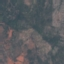

In [19]:
temp_class = random.choice(class_name)
index = random.randint(0,600)
print(temp_class)
Image.open(train_path / temp_class / os.listdir(train_path / temp_class)[index])

In [20]:
# Define the transformation for the dataset
train_resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    # transforms.RandomResizedCrop(224),
    # transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

valid_resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    # transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

resnet_train_dataset = datasets.ImageFolder(root=train_path, transform=train_resnet_transform)
resnet_train_loader = DataLoader(resnet_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

resnet_valid_dataset = datasets.ImageFolder(root=valid_path, transform=valid_resnet_transform)
resnet_valid_loader = DataLoader(resnet_valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
IMG_CHANNEL, IMG_WIDTH, IMG_HEIGHT = resnet_train_dataset[0][0].shape[0], resnet_train_dataset[0][0].shape[1], resnet_train_dataset[0][0].shape[2]
print(IMG_CHANNEL, IMG_WIDTH, IMG_HEIGHT)

3 224 224


(-0.5, 223.5, 223.5, -0.5)

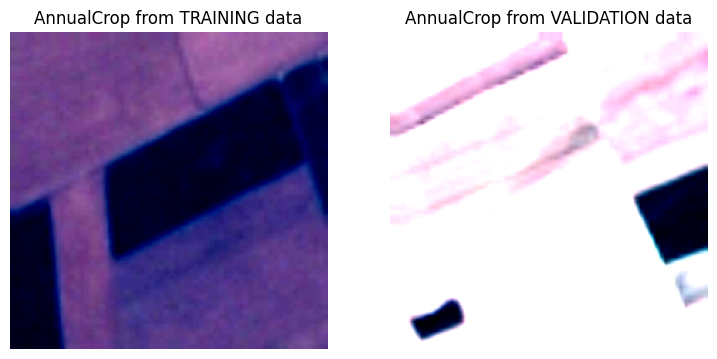

In [22]:
# check the data from train and valid dataset
fig = plt.figure(figsize=(9, 9))

img, label = resnet_train_dataset[index]
fig.add_subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title(f"{class_name[label]} from TRAINING data")
plt.axis(False)

img, label = resnet_valid_dataset[index]
fig.add_subplot(1, 2, 2)
plt.imshow(img.permute(1, 2, 0))
plt.title(f"{class_name[label]} from VALIDATION data")
plt.axis(False)

In [23]:
def create_resnet():
    model_resnet = torchvision.models.resnet34(weights='DEFAULT').to(device)

    for param in model_resnet.parameters():
        param.requires_grad = False

    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)

    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_name)

    # Recreate the classifier layer and seed it to the target device
    in_features = model_resnet.fc.in_features
    model_resnet.fc = torch.nn.Linear(
        in_features=in_features,
        out_features=output_shape, # same number of output units as our number of classes
        ).to(device)

    return model_resnet

In [24]:
model_resnet = create_resnet()

In [25]:
# Define loss and optimizer
resnet_loss_fn = nn.CrossEntropyLoss()
resnet_optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001)

In [26]:
# Setup training and save the results
EPOCH = 5

results_resnet = engine.train(
    model=model_resnet,
    train_dataloader=resnet_train_loader,
    test_dataloader=resnet_valid_loader,
    optimizer=resnet_optimizer,
    loss_fn=resnet_loss_fn,
    epochs=EPOCH,
    device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7496 | train_acc: 0.7895 | test_loss: 0.3971 | test_acc: 0.8814
Epoch: 2 | train_loss: 0.3632 | train_acc: 0.8870 | test_loss: 0.2860 | test_acc: 0.9126
Epoch: 3 | train_loss: 0.3026 | train_acc: 0.9021 | test_loss: 0.2616 | test_acc: 0.9135
Epoch: 4 | train_loss: 0.2730 | train_acc: 0.9097 | test_loss: 0.2304 | test_acc: 0.9234
Epoch: 5 | train_loss: 0.2557 | train_acc: 0.9146 | test_loss: 0.2285 | test_acc: 0.9235


In [27]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

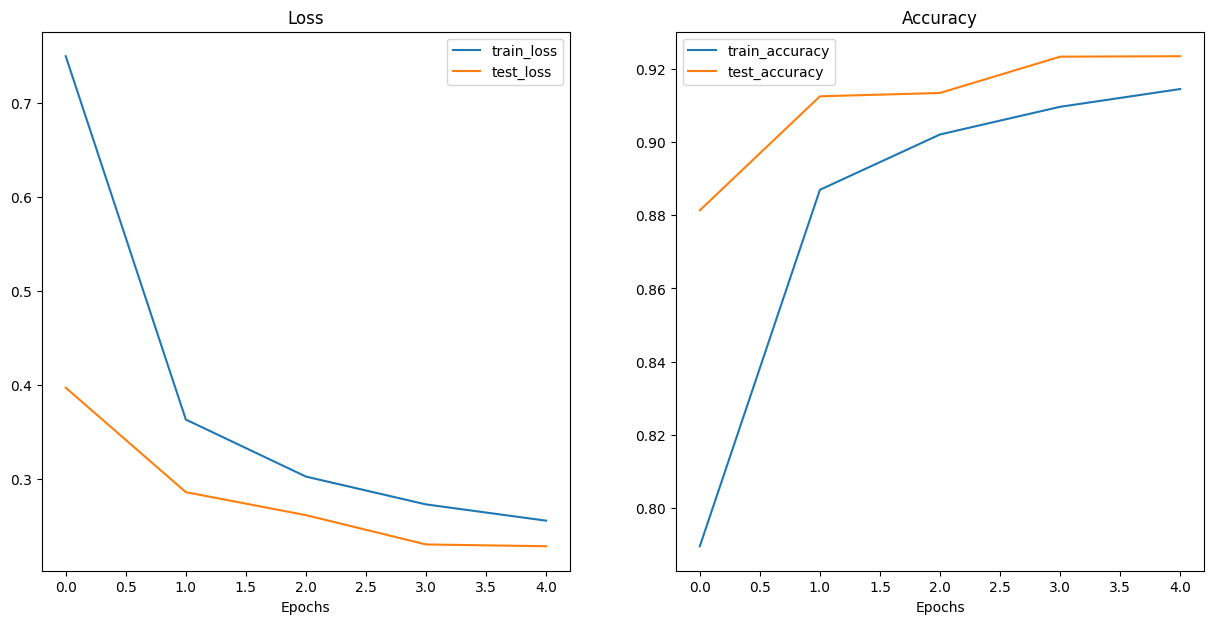

In [28]:
# from going_modular.going_modular import utils

plot_loss_curves(results_resnet)

In [29]:
%%capture
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

In [30]:
print(f"Gradio version: {gr.__version__}")

Gradio version: 3.39.0


In [32]:
from typing import Dict, List, Tuple

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: transforms = None,
                        device: torch.device=device
                        ):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    # plt.figure()
    plt.imshow(img)
    plt.title(
        f"""
        Pred: {class_names[target_image_pred_label]}
        Prob: {target_image_pred_probs.max():.3f}
        """
    )
    plt.axis(False)

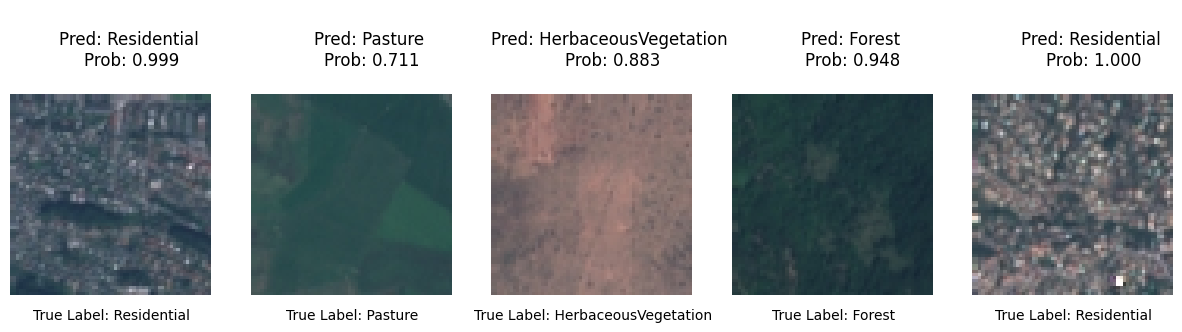

In [34]:
from pathlib import Path

num_images_to_plot = 5
test_image_path_list = list(Path(test_path).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
fig = plt.figure(figsize=(15,5))
for position, image_path in enumerate(test_image_path_sample):
    ax = fig.add_subplot(1, num_images_to_plot, position+1)
    pred_and_plot_image(model=model_resnet,
                        image_path=image_path,
                        class_names=class_name,
                        transform=train_resnet_transform, # optionally pass in a specified transform from our pretrained model weights
                        image_size=(IMG_WIDTH, IMG_HEIGHT)
                        )
    ax.text(32,70, f"True Label: {image_path.parent.name}", ha='center', va='center')

In [35]:
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = train_resnet_transform(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    model_resnet.eval()
    with torch.inference_mode():
      pred_probs = torch.softmax(model_resnet(img.to(device)), dim=1)

    target_image_pred_label = class_name[torch.argmax(pred_probs, dim=1)[0].item()]

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_name[i]: float(pred_probs[0][i]) for i in range(len(class_name))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time, target_image_pred_label

In [44]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_path).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time, pred_label = predict(img=image)
print(f"Prediction label: \n{pred_label}")
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: /content/data/EuroSAT_reorganized/test/Forest/Forest_650.jpg

Prediction label: 
Forest
Prediction label and probability dictionary: 
{'AnnualCrop': 5.685971336788498e-05, 'Forest': 0.9956320524215698, 'HerbaceousVegetation': 0.0005400376976467669, 'Highway': 0.0005346057587303221, 'Industrial': 1.561447061249055e-05, 'Pasture': 0.0003407931362744421, 'PermanentCrop': 4.815532520296983e-06, 'Residential': 2.2136347979540005e-05, 'River': 0.0001910403952933848, 'SeaLake': 0.0026621127035468817}
Prediction time: 0.01116 seconds


In [47]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=5)]
example_list

[['/content/data/EuroSAT_reorganized/test/PermanentCrop/PermanentCrop_879.jpg'],
 ['/content/data/EuroSAT_reorganized/test/Residential/Residential_1079.jpg'],
 ['/content/data/EuroSAT_reorganized/test/PermanentCrop/PermanentCrop_381.jpg'],
 ['/content/data/EuroSAT_reorganized/test/Industrial/Industrial_836.jpg'],
 ['/content/data/EuroSAT_reorganized/test/SeaLake/SeaLake_2235.jpg']]

In [49]:
import gradio as gr

# Create title, description and article strings
title = "EuroSAT Practice"
description = "Using ResNet34 to classify EuroSAT dataset"
article = ""

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1a520e2396e99b3704.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [50]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
eurosat_practice_demo_path = Path("demos/eurosat_practice/")

# Remove files that might already exist there and create new directory
if eurosat_practice_demo_path.exists():
    shutil.rmtree(eurosat_practice_demo_path)
    eurosat_practice_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    eurosat_practice_demo_path.mkdir(parents=True,
                                    exist_ok=True)

# Check what's in the folder
!ls demos/eurosat_practice/

In [62]:
import shutil
from pathlib import Path

# 1. Create an examples directory
eurosat_practice_examples_path = eurosat_practice_demo_path / "examples"
eurosat_practice_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
eurosat_practice_examples = [Path(i[0]) for i in example_list]

# 3. Copy the three random images to the examples directory
for example in eurosat_practice_examples:
    destination = eurosat_practice_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying /content/data/EuroSAT_reorganized/test/PermanentCrop/PermanentCrop_879.jpg to demos/eurosat_practice/examples/PermanentCrop_879.jpg
[INFO] Copying /content/data/EuroSAT_reorganized/test/Residential/Residential_1079.jpg to demos/eurosat_practice/examples/Residential_1079.jpg
[INFO] Copying /content/data/EuroSAT_reorganized/test/PermanentCrop/PermanentCrop_381.jpg to demos/eurosat_practice/examples/PermanentCrop_381.jpg
[INFO] Copying /content/data/EuroSAT_reorganized/test/Industrial/Industrial_836.jpg to demos/eurosat_practice/examples/Industrial_836.jpg
[INFO] Copying /content/data/EuroSAT_reorganized/test/SeaLake/SeaLake_2235.jpg to demos/eurosat_practice/examples/SeaLake_2235.jpg


In [64]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(eurosat_practice_examples_path)]
example_list

[['examples/PermanentCrop_381.jpg'],
 ['examples/Industrial_836.jpg'],
 ['examples/Residential_1079.jpg'],
 ['examples/SeaLake_2235.jpg'],
 ['examples/PermanentCrop_879.jpg']]

In [66]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=model_resnet,
                 target_dir="models",
                 model_name="09_pretrained_resnet_eurosat.pth")

[INFO] Saving model to: models/09_pretrained_resnet_eurosat.pth


In [67]:
import shutil

# Create a source path for our target model
resnet_eurosat_model_path = "models/09_pretrained_resnet_eurosat.pth"

# Create a destination path for our target model
resnet_eurosat_model_destination = eurosat_practice_demo_path / resnet_eurosat_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {resnet_eurosat_model_path} to {resnet_eurosat_model_destination}")

    # Move the model
    shutil.move(src=resnet_eurosat_model_path,
                dst=resnet_eurosat_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {resnet_eurosat_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {resnet_eurosat_model_destination}: {resnet_eurosat_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_resnet_eurosat.pth to demos/eurosat_practice/09_pretrained_resnet_eurosat.pth
[INFO] Model move complete.


In [68]:
%%writefile demos/eurosat_practice/model.py
import torch
import torchvision

from torch import nn

def create_resnet():
    transforms = transforms.Compose([
      transforms.Resize((224, 224)),   #must same as here
      # transforms.RandomResizedCrop(224),
      # transforms.RandomHorizontalFlip(), # data augmentation
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
    ])
    model_resnet = torchvision.models.resnet34(weights='DEFAULT').to(device)

    for param in model_resnet.parameters():
        param.requires_grad = False

    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)

    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_name)

    # Recreate the classifier layer and seed it to the target device
    in_features = model_resnet.fc.in_features
    model_resnet.fc = torch.nn.Linear(
        in_features=in_features,
        out_features=output_shape, # same number of output units as our number of classes
        ).to(device)

    return model_resnet, transform

Writing demos/eurosat_practice/model.py


In [70]:
%%writefile demos/eurosat_practice/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_resnet
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

### 2. Model and transforms preparation ###

# Create resnet model
resnet, resnet_transforms = create_resnet()

# Load saved weights
resnet.load_state_dict(
    torch.load(
        f="09_pretrained_resnet_eurosat.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = train_resnet_transform(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    model_resnet.eval()
    with torch.inference_mode():
      pred_probs = torch.softmax(model_resnet(img.to(device)), dim=1)

    target_image_pred_label = class_name[torch.argmax(pred_probs, dim=1)[0].item()]

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_name[i]: float(pred_probs[0][i]) for i in range(len(class_name))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time, target_image_pred_label

### 4. Gradio app ###

# Create title, description and article strings

# Create title, description and article strings
title = "EuroSAT Practice"
description = "Using ResNet34 to classify EuroSAT dataset"
article = ""

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/eurosat_practice/app.py


In [71]:
%%writefile demos/eurosat_practice/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/eurosat_practice/requirements.txt


In [72]:
# Change into and then zip the eurosat_practice folder but exclude certain files
!cd demos/eurosat_practice && zip -r ../eurosat_practice.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/eurosat_practice.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: 09_pretrained_resnet_eurosat.pth (deflated 7%)
  adding: app.py (deflated 57%)
  adding: examples/ (stored 0%)
  adding: examples/PermanentCrop_381.jpg (deflated 3%)
  adding: examples/Industrial_836.jpg (deflated 2%)
  adding: examples/Residential_1079.jpg (deflated 2%)
  adding: examples/SeaLake_2235.jpg (deflated 5%)
  adding: examples/PermanentCrop_879.jpg (deflated 2%)
  adding: model.py (deflated 53%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>